# Approach 2

In our first approach we have seen the influence of data's dimensionality to model performance. Here we try to perform feature selection process to improve our logstic regression model via boruta.

## What is Boruta?
Feature selection with the Boruta algorithm. Boruta is an all relevant feature selection wrapper algorithm, capable of working with any classification method that output variable importance measure (VIM); by default, Boruta uses Random Forest.

https://www.datasciencecentral.com/profiles/blogs/select-important-variables-using-boruta-algorithm

Thus, here we do the following:
1. Train logistic regression model
2. Perform boruta
3. Retrain with boruta
4. Make our final predictions

In [19]:
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from eli5.sklearn import PermutationImportance
from sklearn import linear_model
import gc
gc.enable()
gc.collect()

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
train_df = pd.read_csv("/Users/JoonH/dont-overfit-ii/train.csv")
test_df = pd.read_csv("/Users/JoonH/dont-overfit-ii/test.csv")

In [3]:
x_train = train_df.drop(['target','id'],axis=1)
y_train = train_df['target']
x_test = test_df.drop(['id'],axis=1)

n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [6]:
def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            
            
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [7]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.075, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(x_train, x_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7269, std: 0.0868.


In [8]:
#Try submitting this
results = prediction_lr
predictions = pd.DataFrame(results, columns = ['target'])
ids = test_df['id']
predictions = pd.concat([ids, predictions], axis = 1, sort=False)
predictions.to_csv('DO2_approach2_log1.csv',index = False)

Now let's use a RandomForest model to implement feature selection via Boruta

In [22]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 200, n_jobs = 4, class_weight = 'balanced', max_depth=5)
boruta_selector = BorutaPy(rfc, n_estimators = 'auto', verbose = 0, max_iter = 5)
boruta_selector.fit(x_train,y_train)

BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=489, n_jobs=4, oob_score=False,
            random_state=<mtrand.RandomState object at 0x0000014E6E8B9F78>,
            verbose=0, warm_start=False),
     max_iter=5, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x0000014E6E8B9F78>,
     two_step=True, verbose=0)

In [23]:
feature_df = pd.DataFrame(train_df.drop(['id','target'],axis=1).columns.tolist(),columns = ['features'])
feature_df['rank'] = boruta_selector.ranking_
feature_df = feature_df.sort_values('rank',ascending=True).reset_index(drop=True)
feature_df.head()

,features,rank
0,65,2
1,117,2
2,33,2
3,91,2
4,217,3


In [24]:
#keep top 50 features
columns_to_keep = feature_df.features[0:50]

In [25]:
boruta_train = train_df[columns_to_keep]
boruta_test = test_df[columns_to_keep]
scaler = StandardScaler()
x_train = scaler.fit_transform(boruta_train)
x_test = scaler.transform(boruta_test)

In [26]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(x_train, x_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7681, std: 0.0909.


In [27]:
results = prediction_lr
predictions = pd.DataFrame(results, columns = ['target'])
ids = test_df['id']
predictions = pd.concat([ids, predictions], axis = 1, sort=False)
predictions.to_csv('dont_overfit_2_approach2.csv',index = False)

This gives us 0.847 on the leaderboard. Nice! Let's see how reducing/increasing the dimensionality affects us.

In [28]:
def train_with_features(num):
    columns_to_keep = feature_df.features[0:num]
    boruta_train = train_df[columns_to_keep]
    boruta_test = test_df[columns_to_keep]
    scaler = StandardScaler()
    x_train = scaler.fit_transform(boruta_train)
    x_test = scaler.transform(boruta_test)
    model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
    oof_lr, prediction_lr, scores = train_model(x_train, x_test, y_train, params=None, model_type='sklearn', model=model)
    return prediction_lr, scores

In [31]:
error_scores = []

for i in range(10,50,10):
    _,scores = train_with_features(i)
    #print(str(i) + " features=>  " +'CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    error_scores.append(np.std(scores))

CV mean score: 0.7669, std: 0.1031.
CV mean score: 0.7506, std: 0.0761.
CV mean score: 0.7662, std: 0.0777.
CV mean score: 0.7681, std: 0.0769.


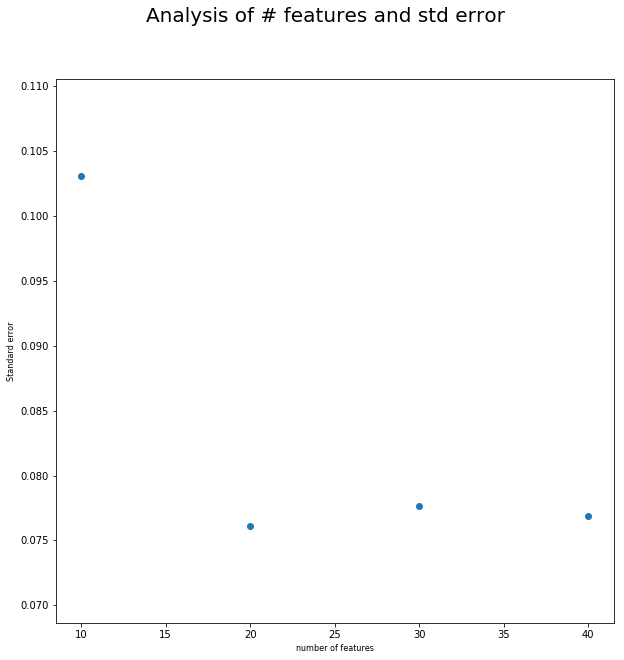

In [33]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.scatter(range(10,50,10), error_scores)
fig.suptitle('Analysis of # features and std error', fontsize=20)
plt.xlabel('number of features', fontsize=8)
plt.ylabel('Standard error', fontsize=8)
plt.show()

Note that as we reduce the dimensionality of top K features to keep, we see an increase in accuracy and standard error. While the CV shows us its average performance over our data set, the std, or standard error, shows us how far away the data points are from the regression line.

This means as we reduce the dimensionality, the hyperplane the model needs to locate to create a decision boundary becomes easier, but as we are relying on less features we are also becoming prone to overfitting. E.g. we may be forcing the model to focus on very specific features to classify, thus failing to generalize.

In [147]:
def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            
            
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [154]:
results,_ = train_with_features(23)
predictions = pd.DataFrame(results, columns = ['target'])
ids = test_df['id']
predictions = pd.concat([ids, predictions], axis = 1, sort=False)
predictions.to_csv('dont_overfit_2_approach2_23_features.csv',index = False)

CV mean score: 0.7631, std: 0.0649.


Unfortunately, this gives us a LB score of 0.846. This seems to tell us that reduction of dimensionality while maintaining the most important features help us train better in our validation, but does not necessarily help generalization.

In [157]:
def train_reduced_feat(num, model):
    columns_to_keep = feature_df.features[0:num]
    boruta_train = train_df[columns_to_keep]
    boruta_test = test_df[columns_to_keep]
    scaler = StandardScaler()
    x_train = scaler.fit_transform(boruta_train)
    x_test = scaler.transform(boruta_test)
    oof_lr, prediction_lr, scores = train_model(x_train, x_test, y_train, params=None, model_type='sklearn', model=model)
    return prediction_lr, scores

In [162]:
log = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
pred_log, _ = train_reduced_feat(23, log)

CV mean score: 0.7631, std: 0.0649.
